In [1]:
import azureml.core
print(azureml.core.VERSION)

1.33.0


In [2]:
import azureml.core
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()

In [3]:
ds = ws.get_default_datastore()

In [4]:
datastores = ws.datastores
for name, ds in datastores.items():
    print(name, ds.datastore_type)

azureml_globaldatasets AzureBlob
workspacefilestore AzureFile
workspaceblobstore AzureBlob


In [5]:
import azureml.data
from azureml.data.azure_storage_datastore import AzureFileDatastore, AzureBlobDatastore

ds.upload(src_dir='./image',
          target_path='image',
          overwrite=True,
          show_progress=True)

Uploading an estimated of 227 files
Uploading ./image\bb8\img_00000004.jpg
Uploaded ./image\bb8\img_00000004.jpg, 1 files out of an estimated total of 227
Uploading ./image\bb8\img_00000009.jpg
Uploaded ./image\bb8\img_00000009.jpg, 2 files out of an estimated total of 227
Uploading ./image\bb8\img_00000025.jpg
Uploaded ./image\bb8\img_00000025.jpg, 3 files out of an estimated total of 227
Uploading ./image\bb8\img_00000026.jpg
Uploaded ./image\bb8\img_00000026.jpg, 4 files out of an estimated total of 227
Uploading ./image\bb8\img_00000027.jpg
Uploaded ./image\bb8\img_00000027.jpg, 5 files out of an estimated total of 227
Uploading ./image\bb8\img_00000001.jpg
Uploaded ./image\bb8\img_00000001.jpg, 6 files out of an estimated total of 227
Uploading ./image\bb8\img_00000007.jpg
Uploaded ./image\bb8\img_00000007.jpg, 7 files out of an estimated total of 227
Uploading ./image\bb8\img_00000020.jpg
Uploaded ./image\bb8\img_00000020.jpg, 8 files out of an estimated total of 227
Uploading ./

$AZUREML_DATAREFERENCE_1bca5c4aee404ef3b3f950802853b599

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cpu_cluster_name = "cpucluster1"

try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_DS3_v2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [7]:
from azureml.core import Experiment
experiment_name = 'cv_step_experiment'

exp = Experiment(workspace=ws, name=experiment_name)

In [8]:
from azureml.train.dnn import TensorFlow

In [18]:
script_params = {
    '--data-folder': ds.as_mount()
}


tf_est = TensorFlow(source_directory='./',
                     entry_script='train.py',
                     use_gpu = False,
                     script_params=script_params,
                     compute_target="cpucluster1",
                     framework_version='2.3',
                     pip_packages=['azureml-dataprep[pandas,fuse]','numpy','scikit-learn','pillow','matplotlib'])

In [19]:
run = exp.submit(tf_est)
run.wait_for_completion(show_output=True)

RunId: cv_step_experiment_1629615686_6fca3506
Web View: https://ml.azure.com/runs/cv_step_experiment_1629615686_6fca3506?wsid=/subscriptions/901e11c6-42ed-4fcc-875a-6bd77390af5b/resourcegroups/azuremlhandsonloab/workspaces/kinfeyamlws&tid=ed483693-3413-4359-9fdf-53a3156196d5

Streaming azureml-logs/55_azureml-execution-tvmps_2c0df9a49367d4a3efb4f72fb72375b1cbe3e8395a82309f57dedc538a800893_d.txt

2021-08-22T07:01:39Z Running following command: /bin/bash -c sudo blobfuse /mnt/batch/tasks/shared/LS_root/jobs/kinfeyamlws/azureml/cv_step_experiment_1629615686_6fca3506/mounts/workspaceblobstore --tmp-path=/mnt/batch/tasks/shared/LS_root/jobs/kinfeyamlws/azureml/cv_step_experiment_1629615686_6fca3506/caches/workspaceblobstore --file-cache-timeout-in-seconds=1000000 --cache-size-mb=22251 -o nonempty -o allow_other --config-file=/mnt/batch/tasks/shared/LS_root/jobs/kinfeyamlws/azureml/cv_step_experiment_1629615686_6fca3506/configs/workspaceblobstore.cfg --log-level=LOG_WARNING
2021-08-22T07:01:

{'runId': 'cv_step_experiment_1629615686_6fca3506',
 'target': 'cpucluster1',
 'status': 'Completed',
 'startTimeUtc': '2021-08-22T07:01:37.26497Z',
 'endTimeUtc': '2021-08-22T07:02:55.690408Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '50d1d7c0-6e34-4bf6-b44f-bd1086924ef6',
  'azureml.git.repository_uri': 'https://github.com/kinfey/HandsOnLab.git',
  'mlflow.source.git.repoURL': 'https://github.com/kinfey/HandsOnLab.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ab321b04c9af92a0f814cc8fe09034d173e6e4c',
  'mlflow.source.git.commit': '1ab321b04c9af92a0f814cc8fe09034d173e6e4c',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder', '$AZU

In [20]:
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = run.register_model(model_name='starwars_model', 
                           model_path='outputs',
                           model_framework=Model.Framework.TENSORFLOW,
                           model_framework_version='2.0',
                           resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=0.5))

In [21]:
run.get_details()

{'runId': 'cv_step_experiment_1629615686_6fca3506',
 'target': 'cpucluster1',
 'status': 'Completed',
 'startTimeUtc': '2021-08-22T07:01:37.26497Z',
 'endTimeUtc': '2021-08-22T07:02:55.690408Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '50d1d7c0-6e34-4bf6-b44f-bd1086924ef6',
  'azureml.git.repository_uri': 'https://github.com/kinfey/HandsOnLab.git',
  'mlflow.source.git.repoURL': 'https://github.com/kinfey/HandsOnLab.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '1ab321b04c9af92a0f814cc8fe09034d173e6e4c',
  'mlflow.source.git.commit': '1ab321b04c9af92a0f814cc8fe09034d173e6e4c',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder', '$AZU

In [22]:
run.get_file_names()

['azureml-logs/55_azureml-execution-tvmps_2c0df9a49367d4a3efb4f72fb72375b1cbe3e8395a82309f57dedc538a800893_d.txt',
 'azureml-logs/65_job_prep-tvmps_2c0df9a49367d4a3efb4f72fb72375b1cbe3e8395a82309f57dedc538a800893_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_2c0df9a49367d4a3efb4f72fb72375b1cbe3e8395a82309f57dedc538a800893_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'logs/azureml/95_azureml.log',
 'logs/azureml/job_prep_azureml.log',
 'logs/azureml/job_release_azureml.log',
 'outputs/starwars_model.h5',
 'outputs/starwars_model.json']

In [23]:
import os

os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

In [24]:

from tensorflow.keras.models import model_from_json

json_file = open('./model/starwars_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("./model/starwars_model.h5")
print("Model loaded from disk.")

Model loaded from disk.


In [41]:
def predict_image(classifier, img):
    import numpy as np
    
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    predicted_class = classifier.predict(imgfeatures)
    i = np.argmax(predicted_class, axis=1)
    return i

In [42]:
def resize_image(img, size):
    from PIL import Image, ImageOps 
    
    print(len(np.array(img).shape))
    
    if(len(np.array(img).shape)>2):
        
        if np.array(img).shape[2] == 4:
            img = img.convert('RGB')
        
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
    
    return newimg

In [43]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

3
3
3


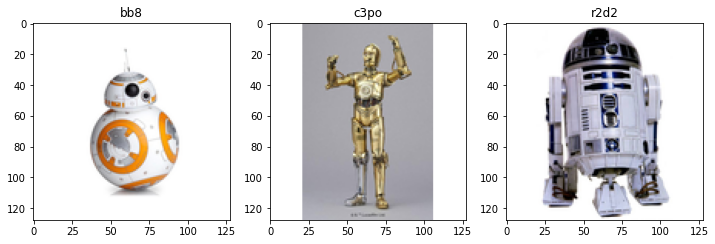

In [44]:

image_urls = []
image_urls.append('001.jpg')
image_urls.append('002.jpg')
image_urls.append('003.jpg')


size = (128,128)

fig = plt.figure(figsize=(12, 8))


for url_idx in range(len(image_urls)):
    img = Image.open(image_urls[url_idx])
    img = np.array(resize_image(img, size))
    class_idx = predict_image(loaded_model, img)
    class_name = classnames[class_idx[0]]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)